In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

train_A_chars = list(train_A_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')

A_train_ds = P300Getter(train_A_raw, eloc, sample_size=72)
A_test_ds = P300Getter(test_A_raw, eloc, sample_size=72, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

A_train_ds.upsample(4)
#A_test_ds.upsample(2)

X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.10it/s]


In [6]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 1024

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True)
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True)

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

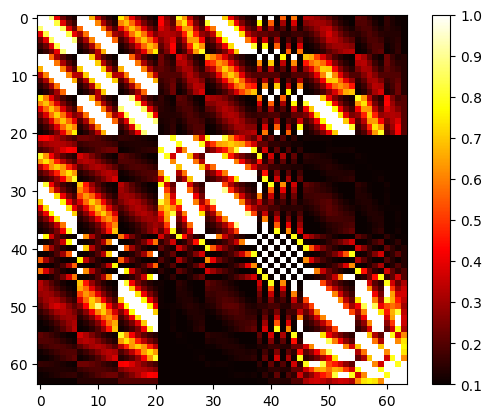

In [10]:
plt.imshow(get_pos_init_graph(eloc), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [13]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

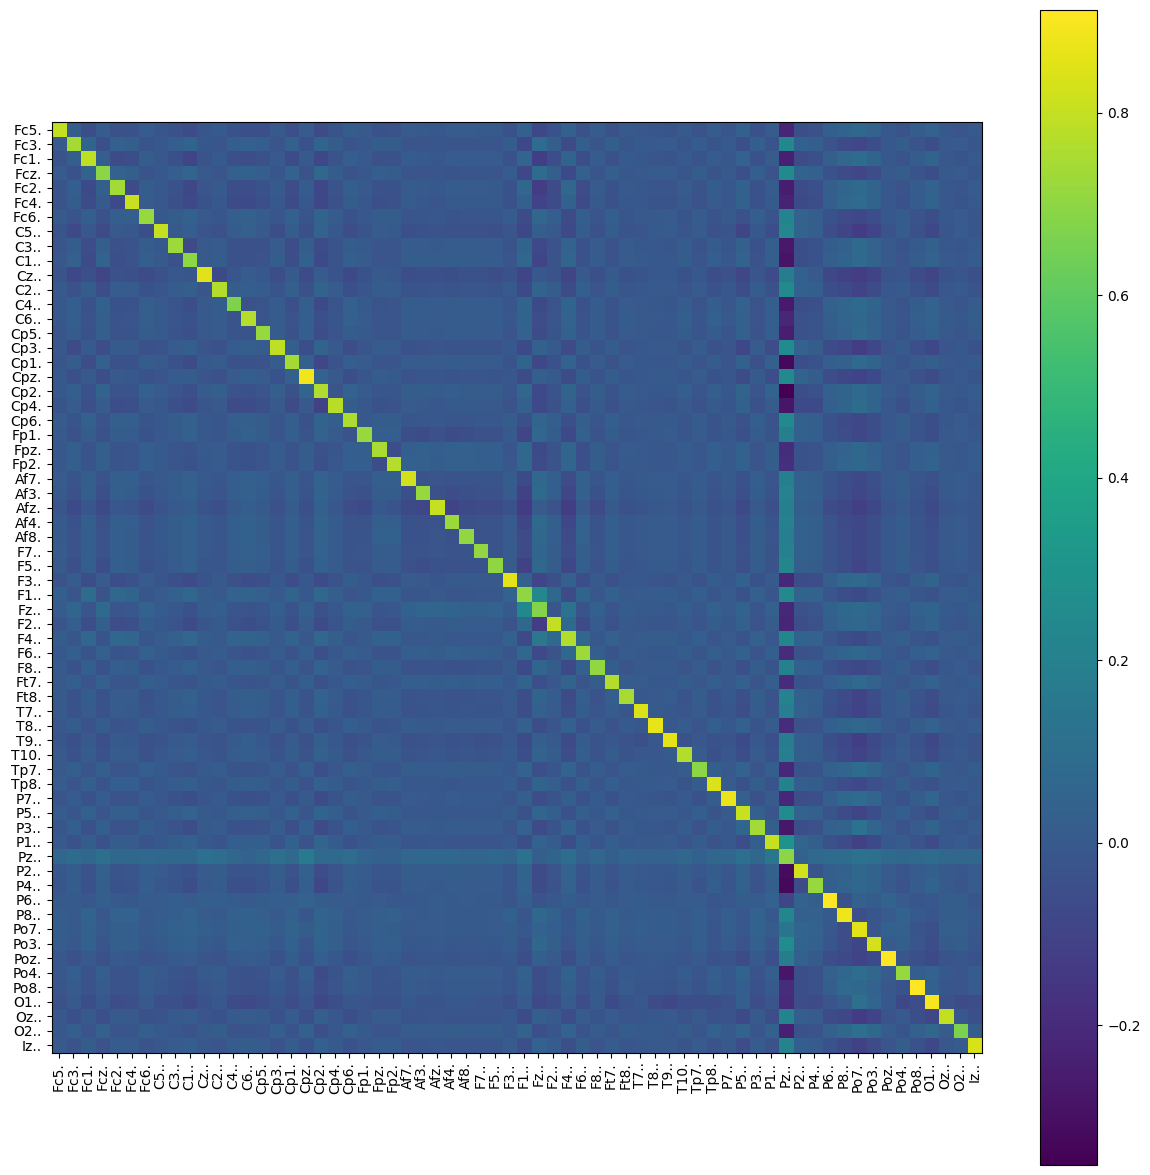

In [41]:
plt.figure(figsize=(15, 15))
plt.imshow(A.cpu().detach().numpy(), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

cuda:0
Training complete in 9m 5s
Accuracy:  0.7058333333333333
F1-score:  0.34658531785081675


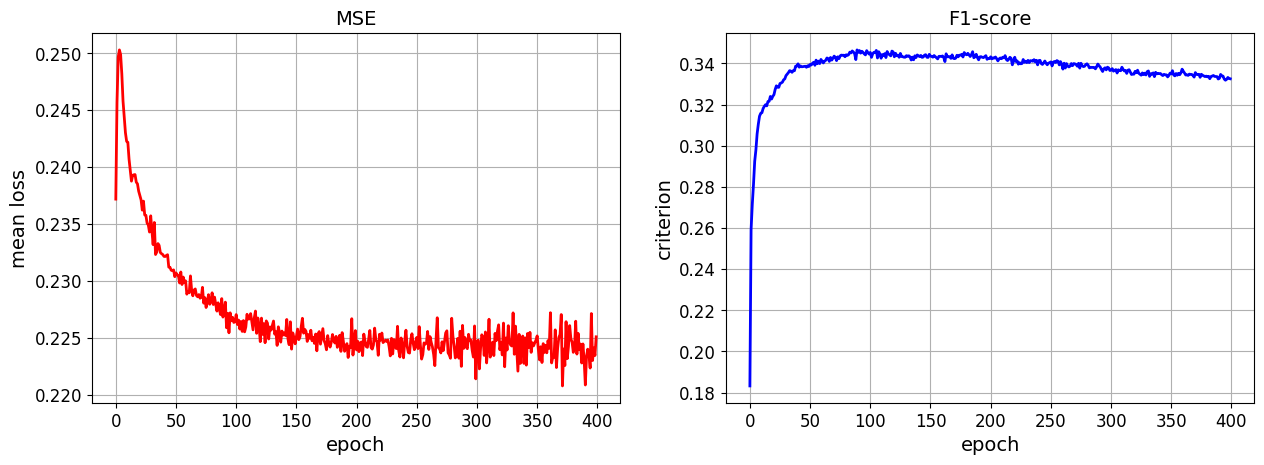

In [17]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Training complete in 8m 53s
Accuracy:  0.7072777777777778
F1-score:  0.37305908449284125


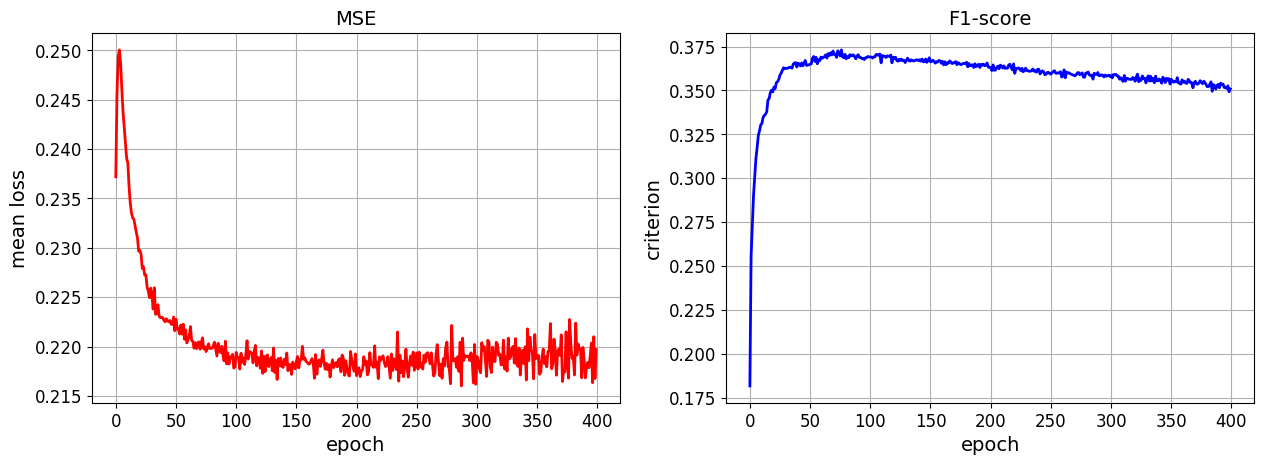

In [11]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2484	 Min Acc: 0.5348	 Acc: 0.5409	 Max Acc: 0.5470	 Balanced Acc: 0.5409	 Positive: 483.6250	 Precision: 0.5449	 Recall: 0.4961	 F1-score: 0.5194	
val	 Loss: 0.2465	 Min Acc: 0.5518	 Acc: 0.5591	 Max Acc: 0.5663	 Balanced Acc: 0.5121	 Positive: 446.2941	 Precision: 0.1746	 Recall: 0.4417	 F1-score: 0.2503	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2461	 Min Acc: 0.5481	 Acc: 0.5542	 Max Acc: 0.5603	 Balanced Acc: 0.5542	 Positive: 503.1667	 Precision: 0.5572	 Recall: 0.5278	 F1-score: 0.5421	
val	 Loss: 0.2469	 Min Acc: 0.5444	 Acc: 0.5517	 Max Acc: 0.5589	 Balanced Acc: 0.5258	 Positive: 470.1176	 Precision: 0.1828	 Recall: 0.4870	 F1-score: 0.2658	
Epoch 29/399
-----

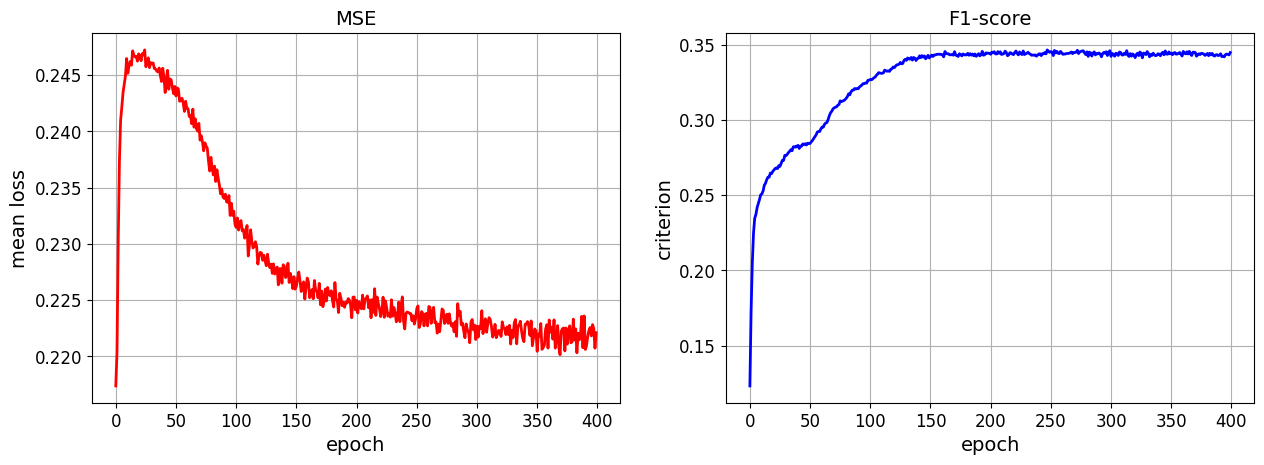

In [7]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2357	 Min Acc: 0.5988	 Acc: 0.6048	 Max Acc: 0.6108	 Balanced Acc: 0.6048	 Positive: 521.5000	 Precision: 0.6067	 Recall: 0.5956	 F1-score: 0.6011	
val	 Loss: 0.2388	 Min Acc: 0.5980	 Acc: 0.6052	 Max Acc: 0.6123	 Balanced Acc: 0.5866	 Positive: 438.7647	 Precision: 0.2247	 Recall: 0.5587	 F1-score: 0.3205	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2215	 Min Acc: 0.6391	 Acc: 0.6449	 Max Acc: 0.6508	 Balanced Acc: 0.6449	 Positive: 536.8333	 Precision: 0.6434	 Recall: 0.6502	 F1-score: 0.6468	
val	 Loss: 0.2285	 Min Acc: 0.6240	 Acc: 0.6311	 Max Acc: 0.6381	 Balanced Acc: 0.6253	 Positive: 431.8235	 Precision: 0.2520	 Recall: 0.6167	 F1-score: 0.3578	
Epoch 29/399
-----

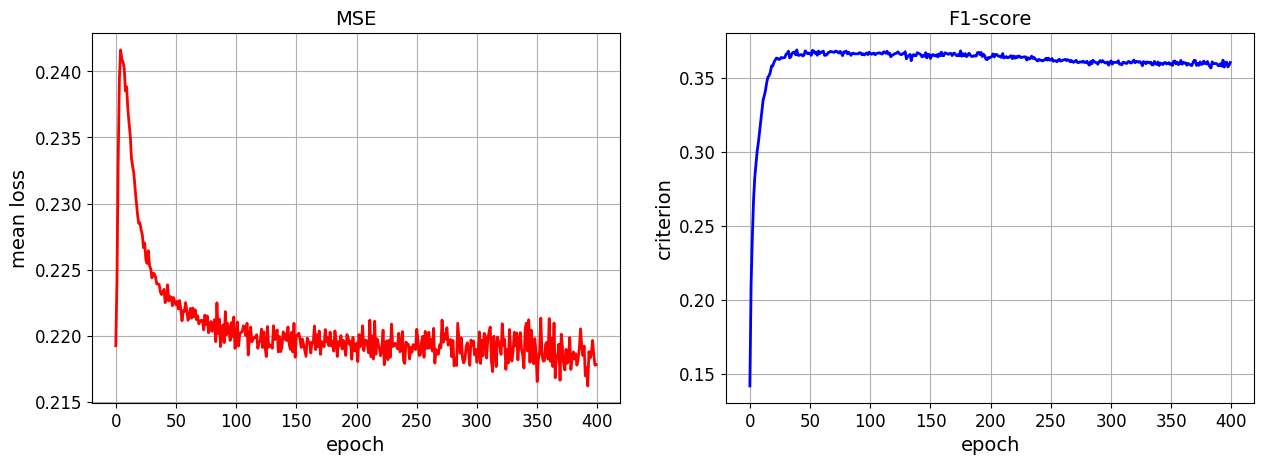

In [10]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2470	 Min Acc: 0.5435	 Acc: 0.5496	 Max Acc: 0.5557	 Balanced Acc: 0.5496	 Positive: 527.4583	 Precision: 0.5500	 Recall: 0.5460	 F1-score: 0.5480	
val	 Loss: 0.2461	 Min Acc: 0.5387	 Acc: 0.5460	 Max Acc: 0.5533	 Balanced Acc: 0.5260	 Positive: 479.2941	 Precision: 0.1826	 Recall: 0.4960	 F1-score: 0.2670	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2389	 Min Acc: 0.5903	 Acc: 0.5964	 Max Acc: 0.6024	 Balanced Acc: 0.5964	 Positive: 553.8750	 Precision: 0.5924	 Recall: 0.6176	 F1-score: 0.6048	
val	 Loss: 0.2381	 Min Acc: 0.5795	 Acc: 0.5867	 Max Acc: 0.5939	 Balanced Acc: 0.5693	 Positive: 452.9412	 Precision: 0.2117	 Recall: 0.5433	 F1-score: 0.3047	
Epoch 29/399
-----

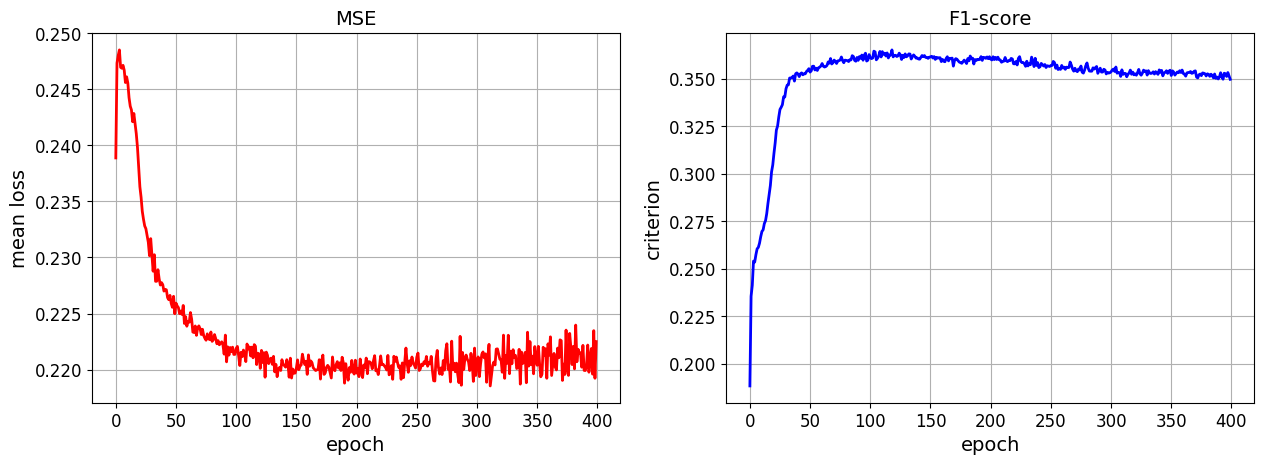

In [40]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = nn.Parameter(data=torch.eye(64, 64).to(my_device).float(), requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2475	 Min Acc: 0.5326	 Acc: 0.5387	 Max Acc: 0.5448	 Balanced Acc: 0.5387	 Positive: 479.3750	 Precision: 0.5429	 Recall: 0.4899	 F1-score: 0.5150	
val	 Loss: 0.2459	 Min Acc: 0.5669	 Acc: 0.5742	 Max Acc: 0.5814	 Balanced Acc: 0.5364	 Positive: 443.7059	 Precision: 0.1908	 Recall: 0.4797	 F1-score: 0.2730	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2433	 Min Acc: 0.5590	 Acc: 0.5651	 Max Acc: 0.5711	 Balanced Acc: 0.5651	 Positive: 504.4583	 Precision: 0.5685	 Recall: 0.5398	 F1-score: 0.5538	
val	 Loss: 0.2428	 Min Acc: 0.5789	 Acc: 0.5861	 Max Acc: 0.5933	 Balanced Acc: 0.5594	 Positive: 445.0588	 Precision: 0.2059	 Recall: 0.5193	 F1-score: 0.2949	
Epoch 29/399
-----

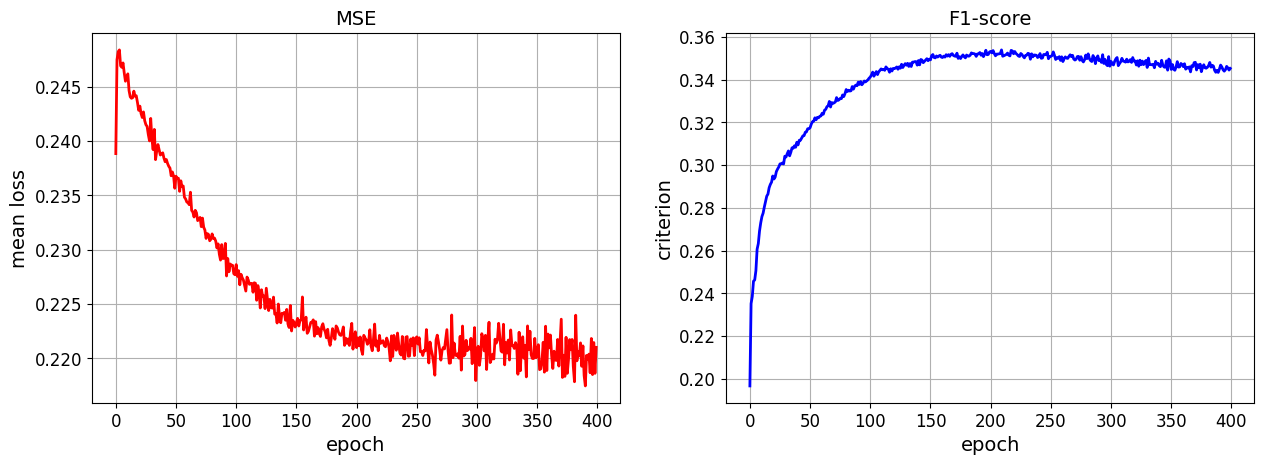

In [9]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.eye(64, 64).to(my_device).float()
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

In [11]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

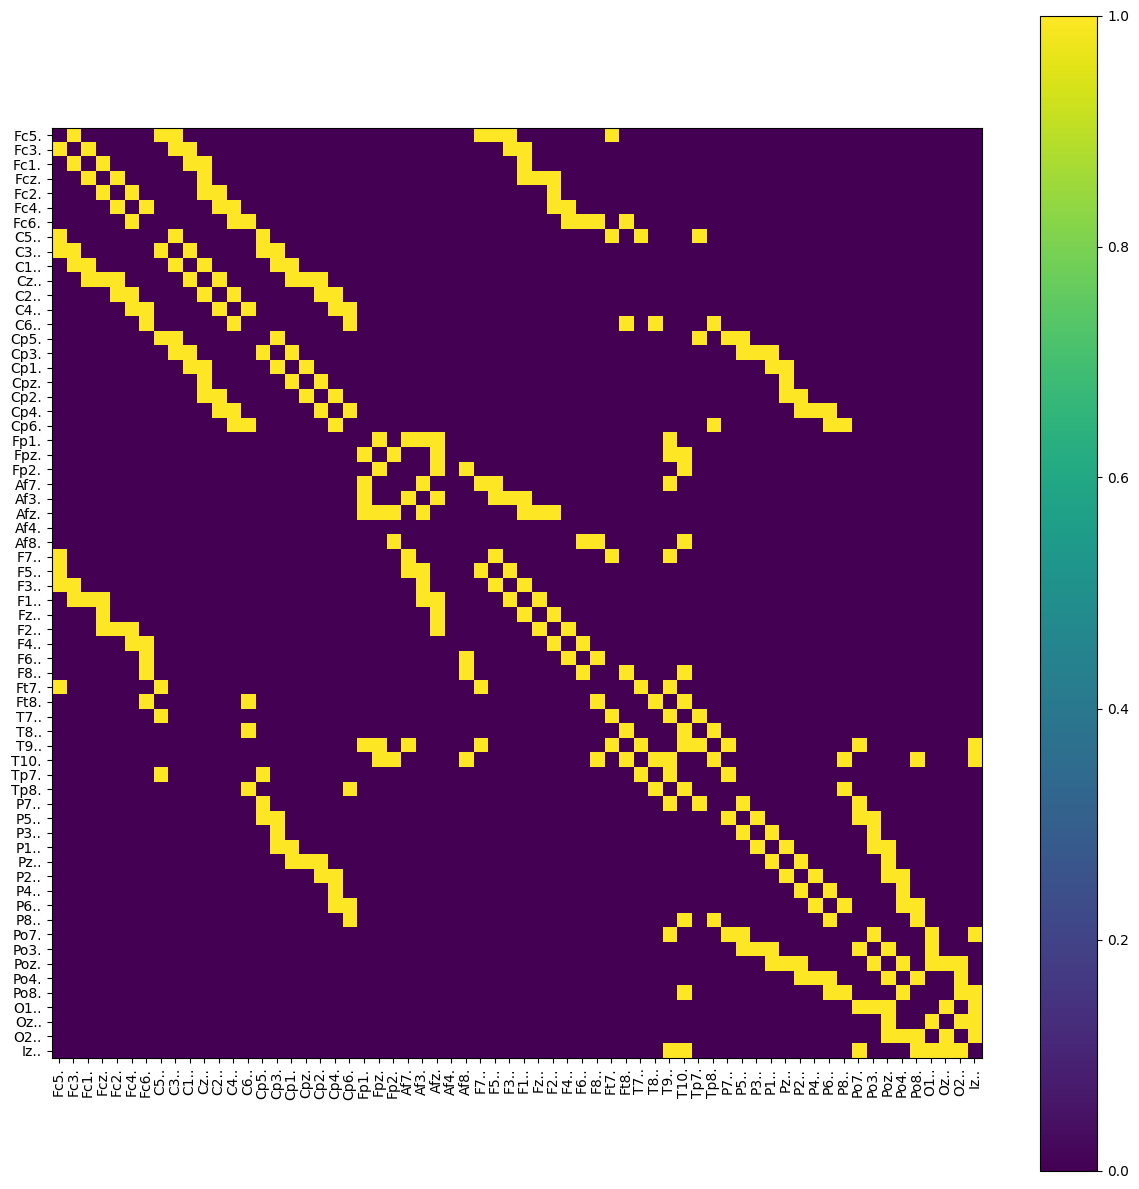

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(get_delaunay_graph(eloc).toarray(), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

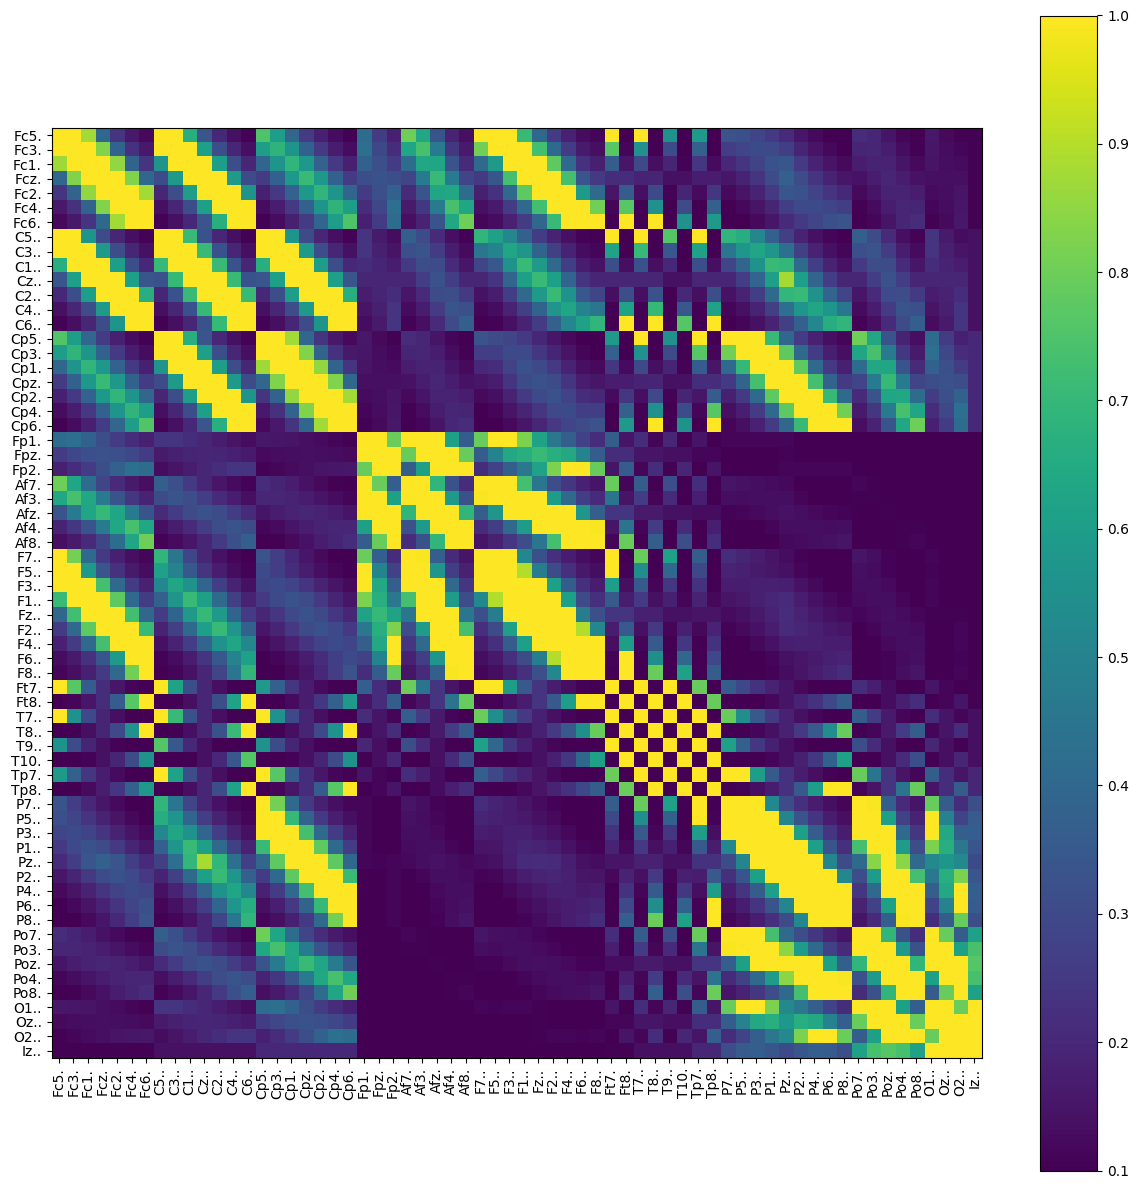

In [39]:
plt.figure(figsize=(15, 15))
plt.imshow(get_pos_init_graph(eloc), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

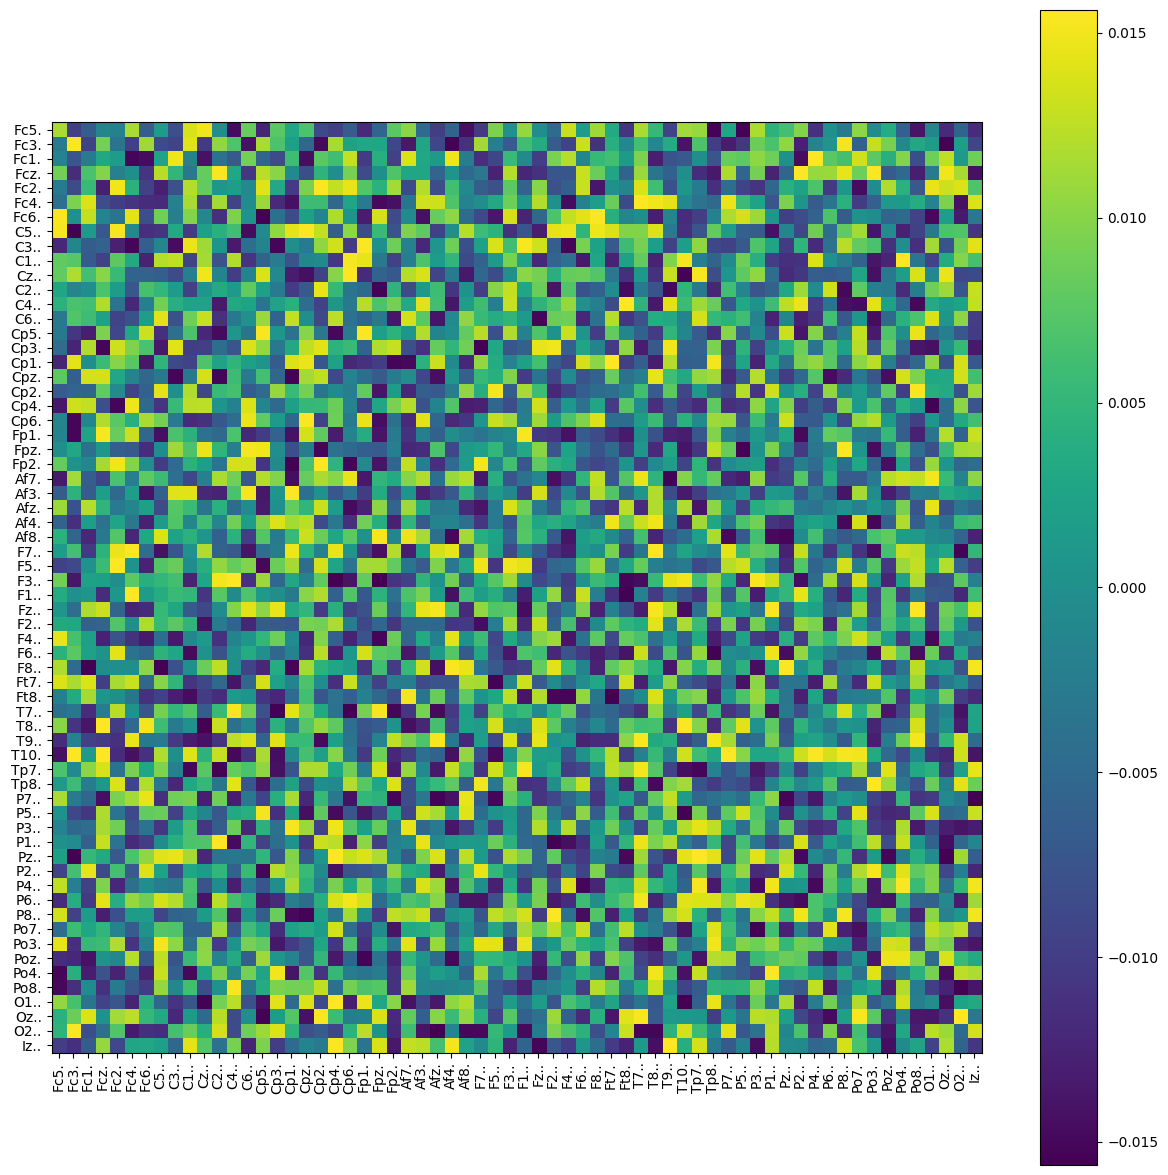

In [14]:
B = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(B, -k, k)

plt.figure(figsize=(15, 15))
plt.imshow(B.cpu().detach().numpy(), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

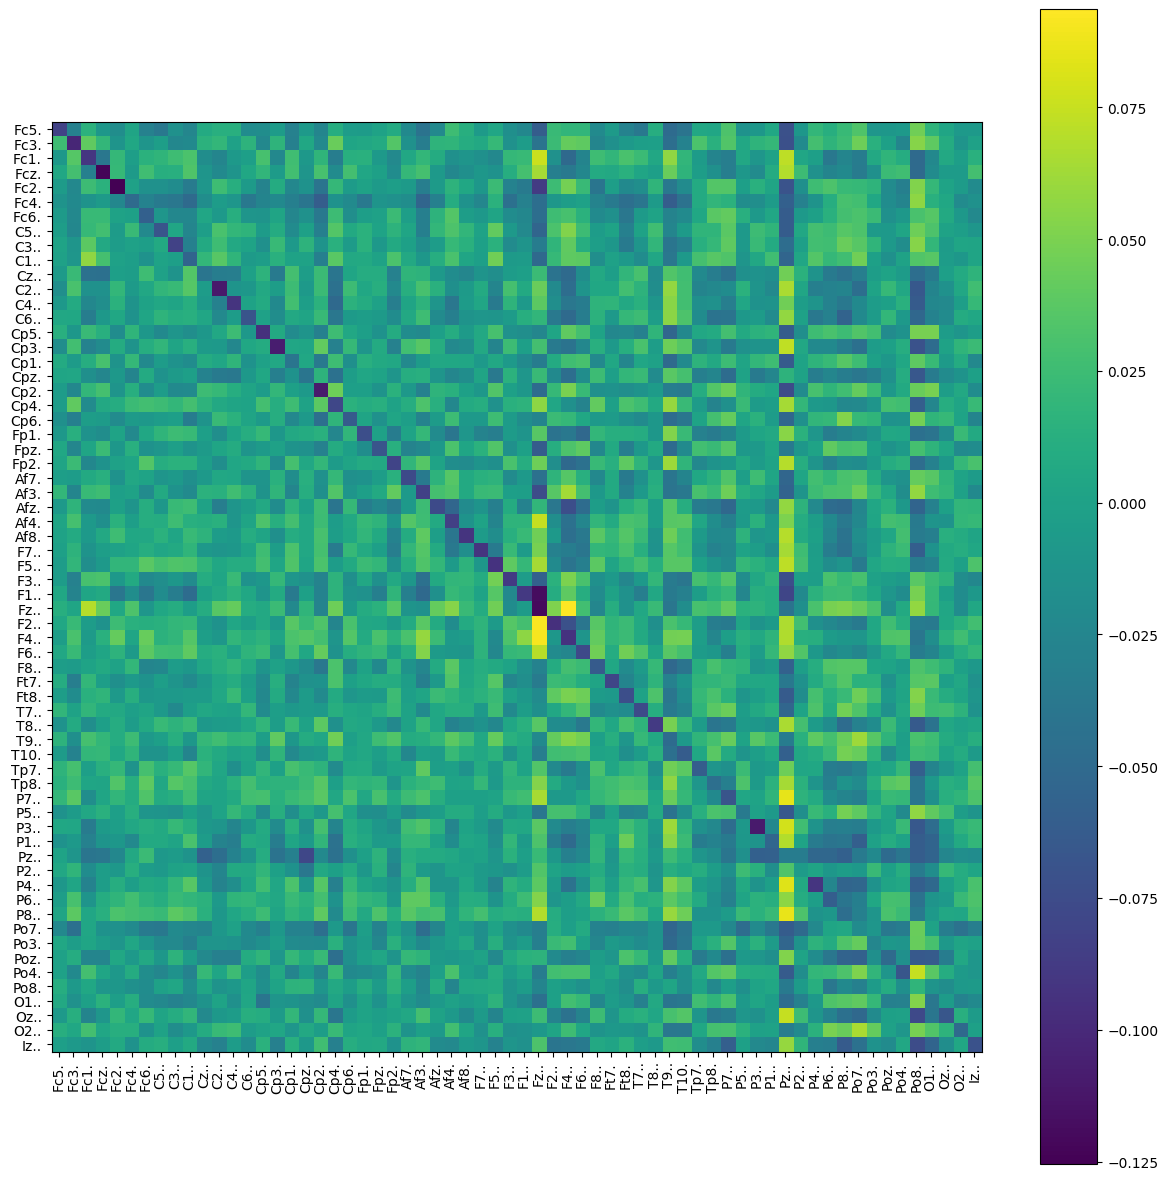

In [34]:
plt.figure(figsize=(15, 15))
plt.imshow(A.cpu().detach().numpy(), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

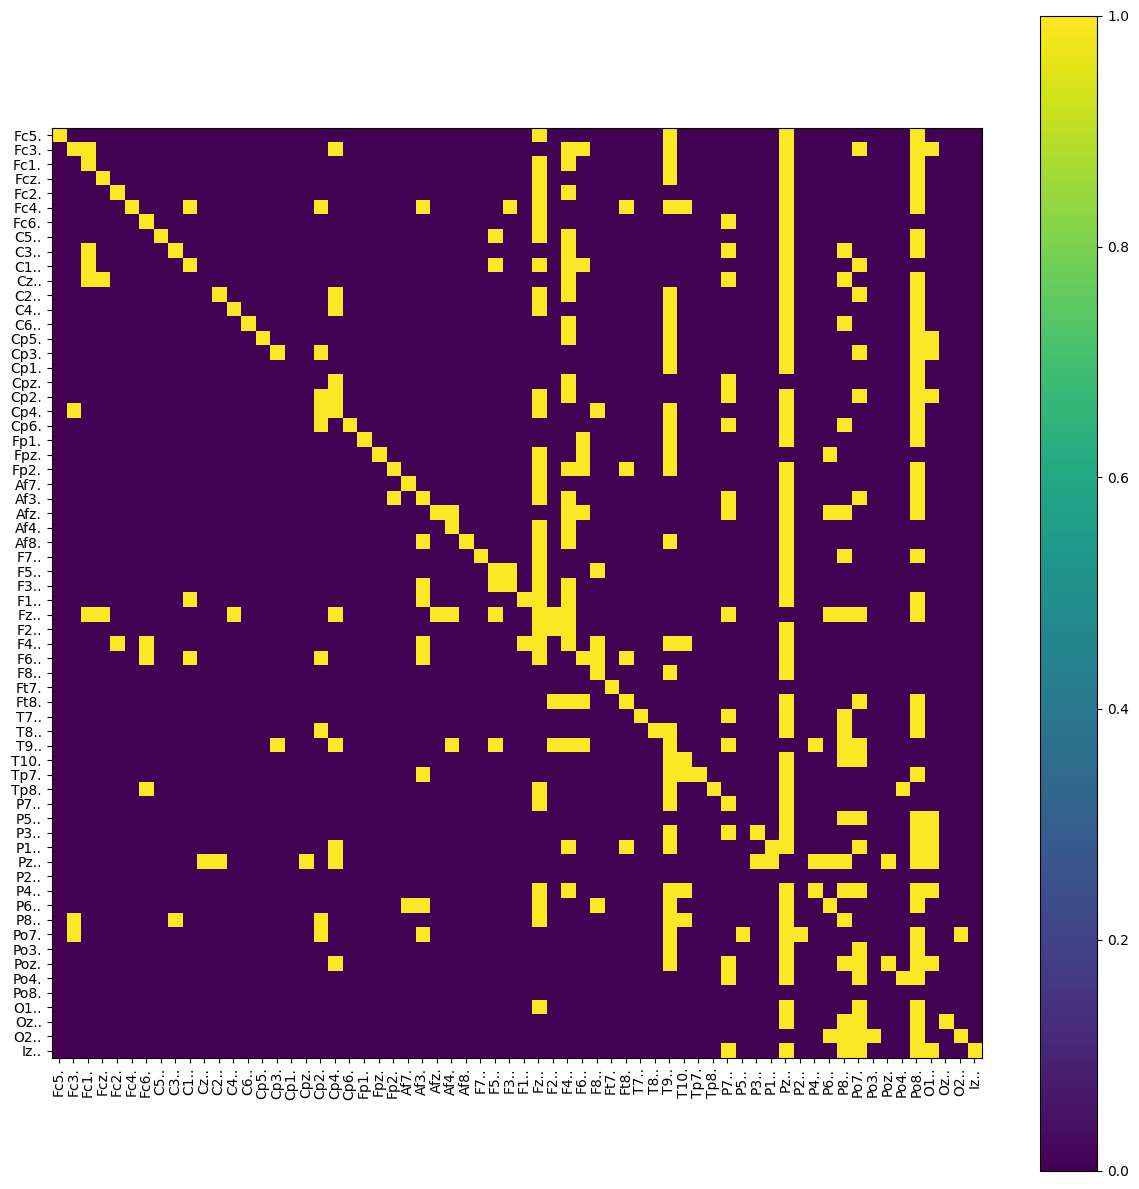

In [37]:
plt.figure(figsize=(15, 15))
clip_const = 0.95

C = torch.ones(64, 64)
C[A == A.clamp(torch.quantile(A, 1- clip_const).item() , torch.quantile(A, clip_const).item())]=0
plt.imshow(C.cpu().detach().numpy(), interpolation='nearest')
plt.xticks(np.arange(64), ch_names.values(), rotation='vertical')
plt.yticks(np.arange(64), ch_names.values(), rotation='horizontal')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

Физиологи: Fz, Cz, P3, P4, Po7, Po8, Pz, Oz.
    
Из шума: Fz, Po7, Po8, Pz.

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2399	 Min Acc: 0.5785	 Acc: 0.5845	 Max Acc: 0.5906	 Balanced Acc: 0.5845	 Positive: 541.3333	 Precision: 0.5830	 Recall: 0.5940	 F1-score: 0.5885	
val	 Loss: 0.2426	 Min Acc: 0.5740	 Acc: 0.5812	 Max Acc: 0.5884	 Balanced Acc: 0.5754	 Positive: 467.0000	 Precision: 0.2141	 Recall: 0.5667	 F1-score: 0.3108	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2291	 Min Acc: 0.6196	 Acc: 0.6256	 Max Acc: 0.6315	 Balanced Acc: 0.6256	 Positive: 528.2500	 Precision: 0.6263	 Recall: 0.6227	 F1-score: 0.6245	
val	 Loss: 0.2313	 Min Acc: 0.6130	 Acc: 0.6201	 Max Acc: 0.6271	 Balanced Acc: 0.6080	 Positive: 434.0588	 Precision: 0.2399	 Recall: 0.5900	 F1-score: 0.3411	
Epoch 29/399
-----

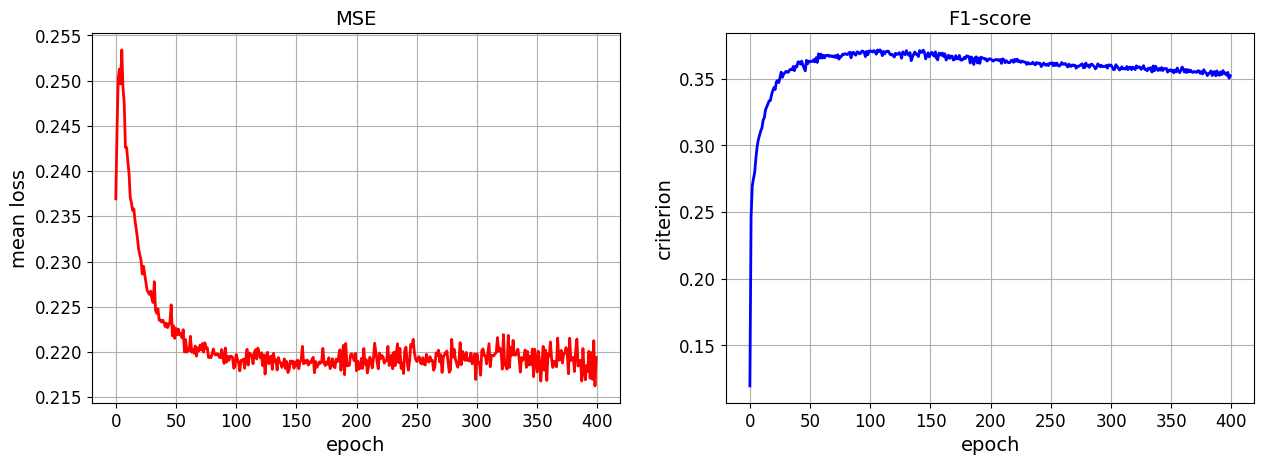

In [7]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2436	 Min Acc: 0.5589	 Acc: 0.5650	 Max Acc: 0.5711	 Balanced Acc: 0.5650	 Positive: 554.0417	 Precision: 0.5623	 Recall: 0.5864	 F1-score: 0.5741	
val	 Loss: 0.2466	 Min Acc: 0.5486	 Acc: 0.5559	 Max Acc: 0.5631	 Balanced Acc: 0.5602	 Positive: 493.7647	 Precision: 0.2025	 Recall: 0.5667	 F1-score: 0.2984	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2400	 Min Acc: 0.5778	 Acc: 0.5838	 Max Acc: 0.5899	 Balanced Acc: 0.5838	 Positive: 521.3333	 Precision: 0.5854	 Recall: 0.5745	 F1-score: 0.5799	
val	 Loss: 0.2411	 Min Acc: 0.5776	 Acc: 0.5848	 Max Acc: 0.5920	 Balanced Acc: 0.5698	 Positive: 456.3529	 Precision: 0.2117	 Recall: 0.5473	 F1-score: 0.3053	
Epoch 29/399
-----

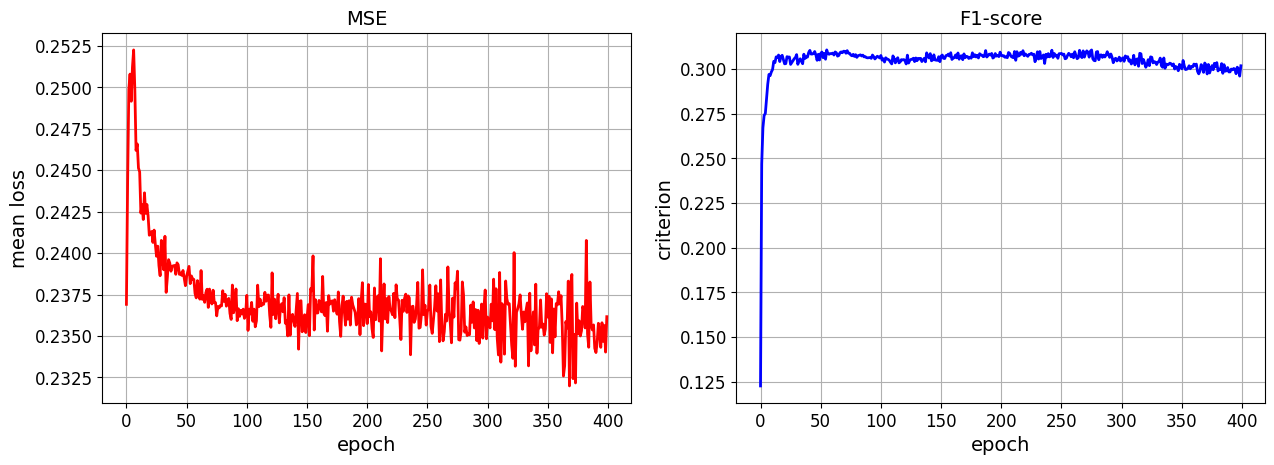

In [8]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

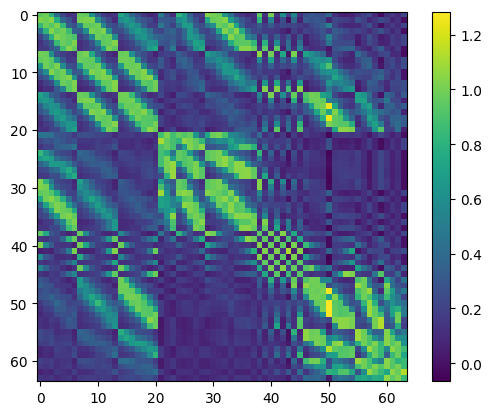

In [25]:
plt.imshow(model_GNN.adj.cpu().detach().numpy(), interpolation='nearest')
plt.colorbar()
plt.show()

In [26]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

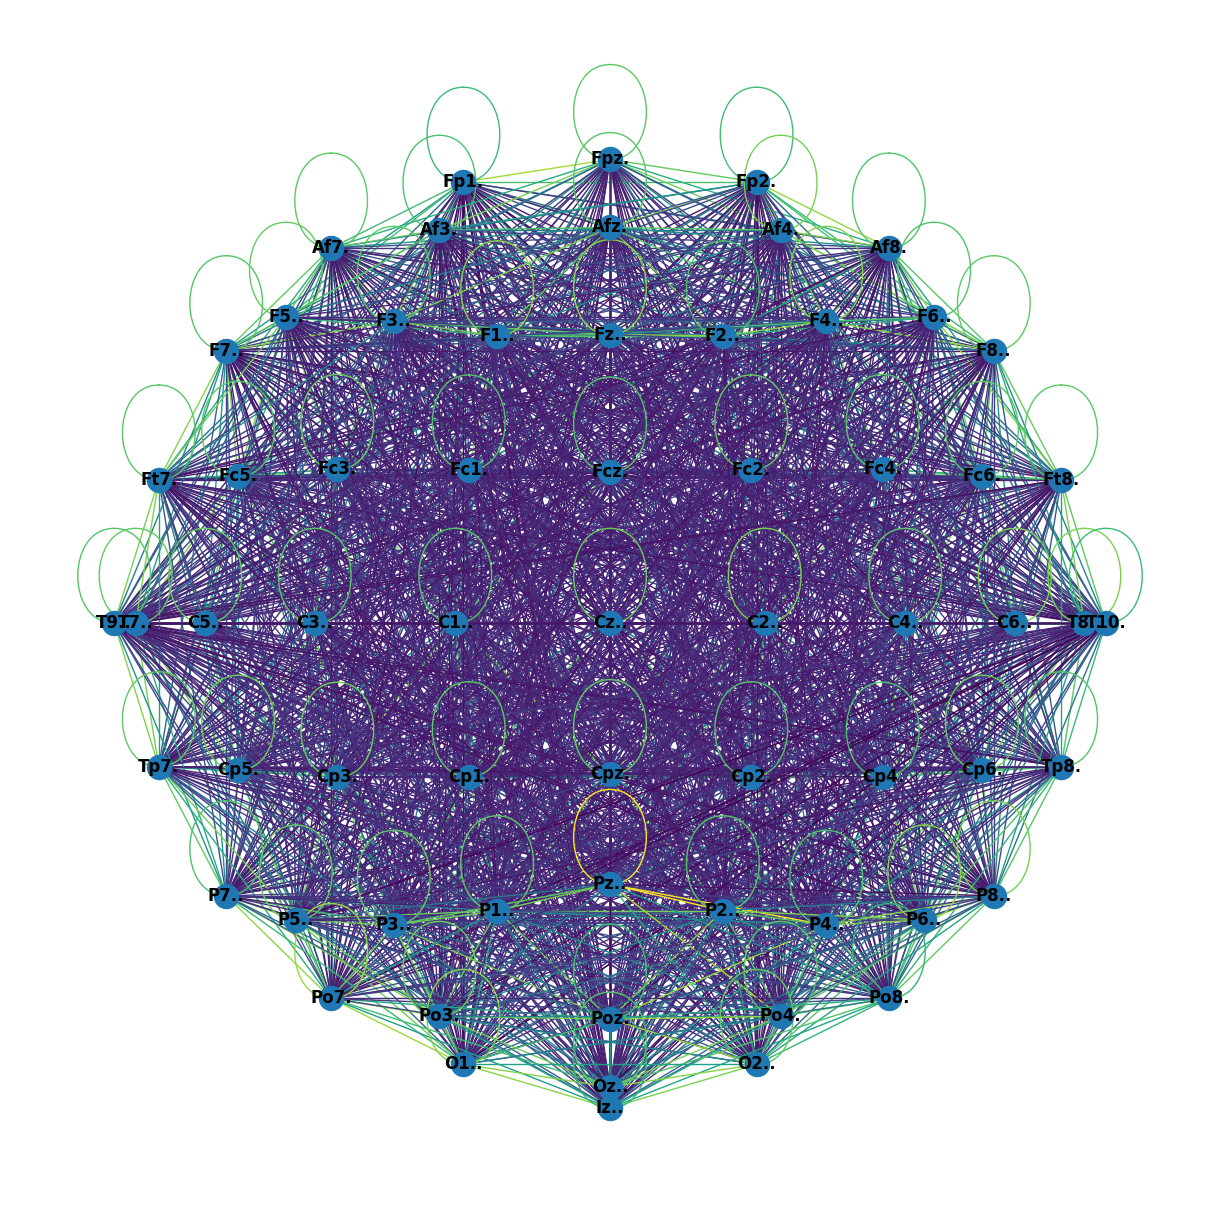

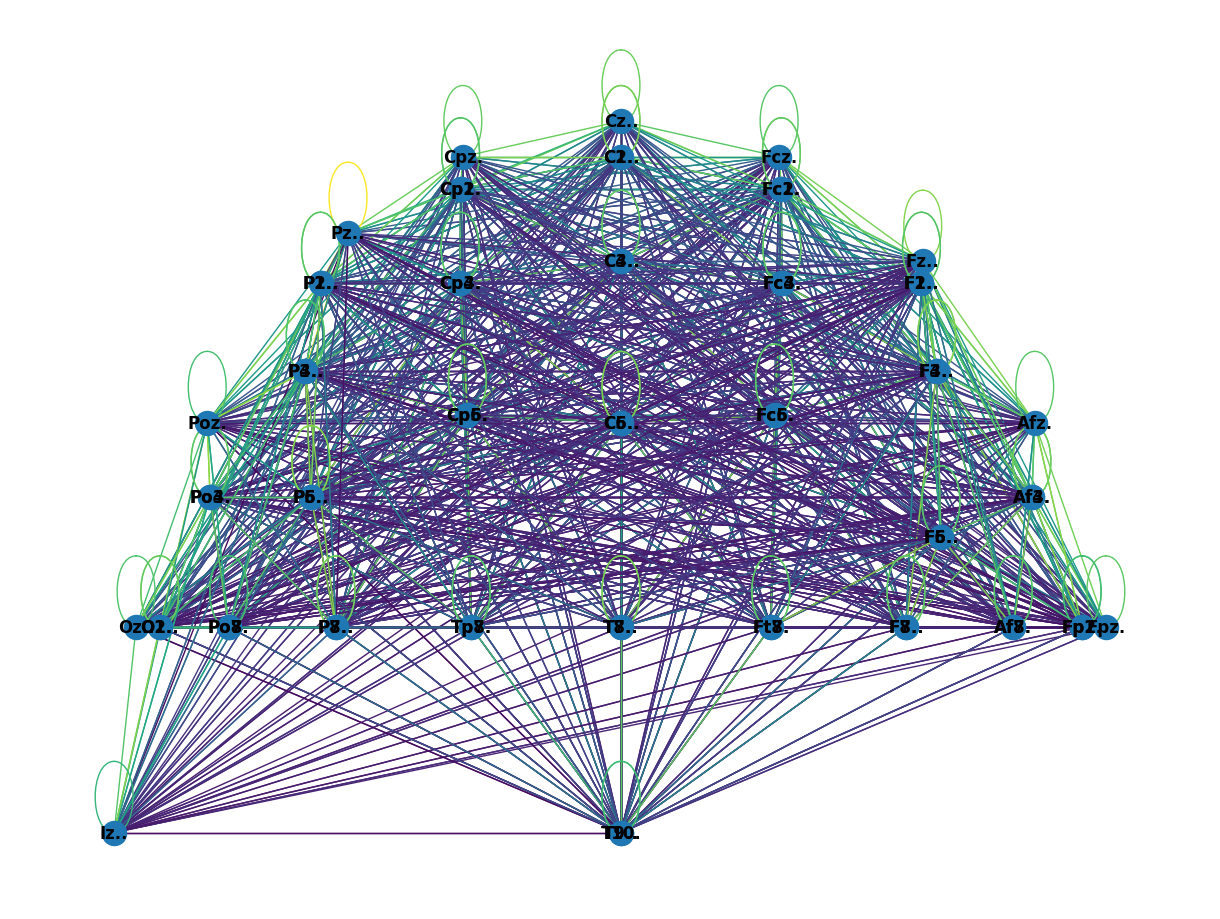

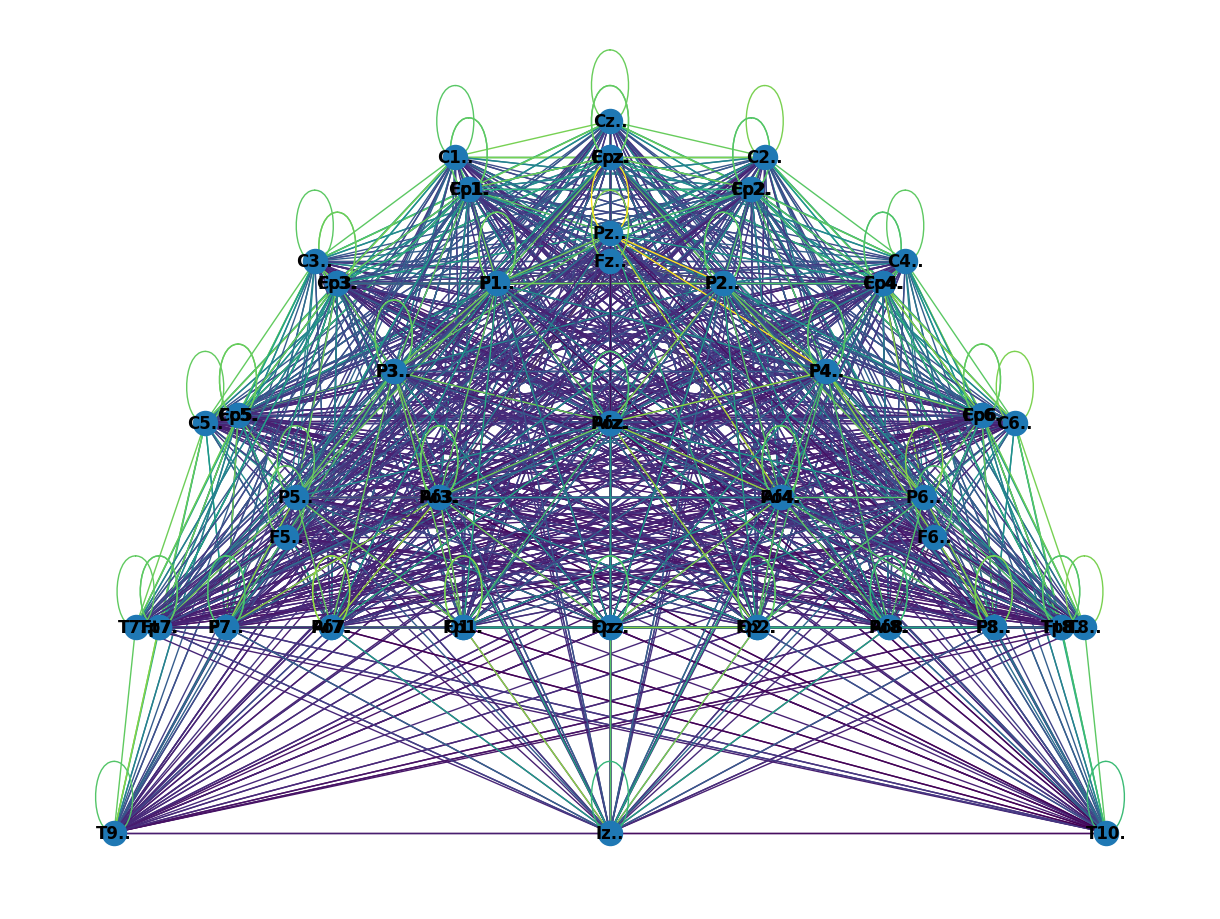

In [27]:
G = nx.from_numpy_array(model_GNN.adj.cpu().detach().numpy())
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

plt.figure(figsize=(12,12)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,:2], edgelist=edges, edge_color=weights)
plt.show()
plt.figure(figsize=(12,9)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,1:], edgelist=edges, edge_color=weights)
plt.show()
plt.figure(figsize=(12,9)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,[0, 2]], edgelist=edges, edge_color=weights)
plt.show()

cuda:0
Epoch 9/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2351	 Min Acc: 0.5991	 Acc: 0.6051	 Max Acc: 0.6111	 Balanced Acc: 0.6051	 Positive: 524.2500	 Precision: 0.6065	 Recall: 0.5985	 F1-score: 0.6025	
val	 Loss: 0.2388	 Min Acc: 0.6000	 Acc: 0.6071	 Max Acc: 0.6142	 Balanced Acc: 0.5967	 Positive: 444.5882	 Precision: 0.2306	 Recall: 0.5810	 F1-score: 0.3302	
Epoch 19/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2239	 Min Acc: 0.6330	 Acc: 0.6389	 Max Acc: 0.6448	 Balanced Acc: 0.6389	 Positive: 536.1667	 Precision: 0.6376	 Recall: 0.6435	 F1-score: 0.6406	
val	 Loss: 0.2292	 Min Acc: 0.6195	 Acc: 0.6266	 Max Acc: 0.6337	 Balanced Acc: 0.6184	 Positive: 432.7647	 Precision: 0.2471	 Recall: 0.6060	 F1-score: 0.3511	
Epoch 29/99
--------

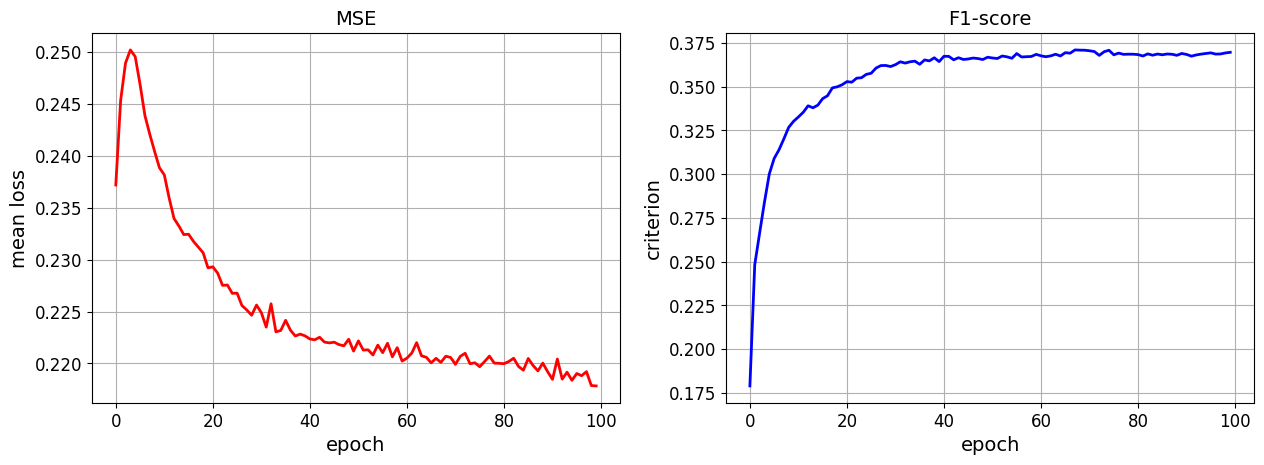

In [8]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

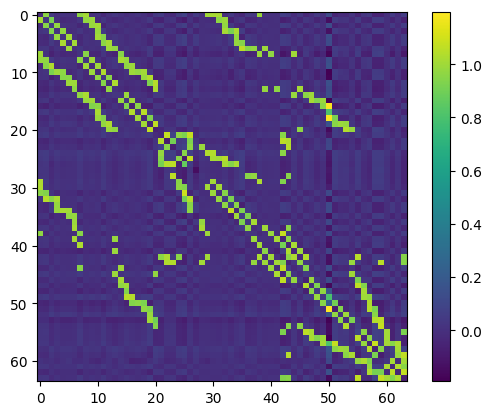

In [35]:
plt.imshow(model_GNN.adj.cpu().detach().numpy(), interpolation='nearest')
plt.colorbar()
plt.show()

In [36]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

In [53]:
a = np.where(np.array(weights) > 0.3)[0]

In [51]:
a = np.append([0], a)

ValueError: (1, 1) is not in list

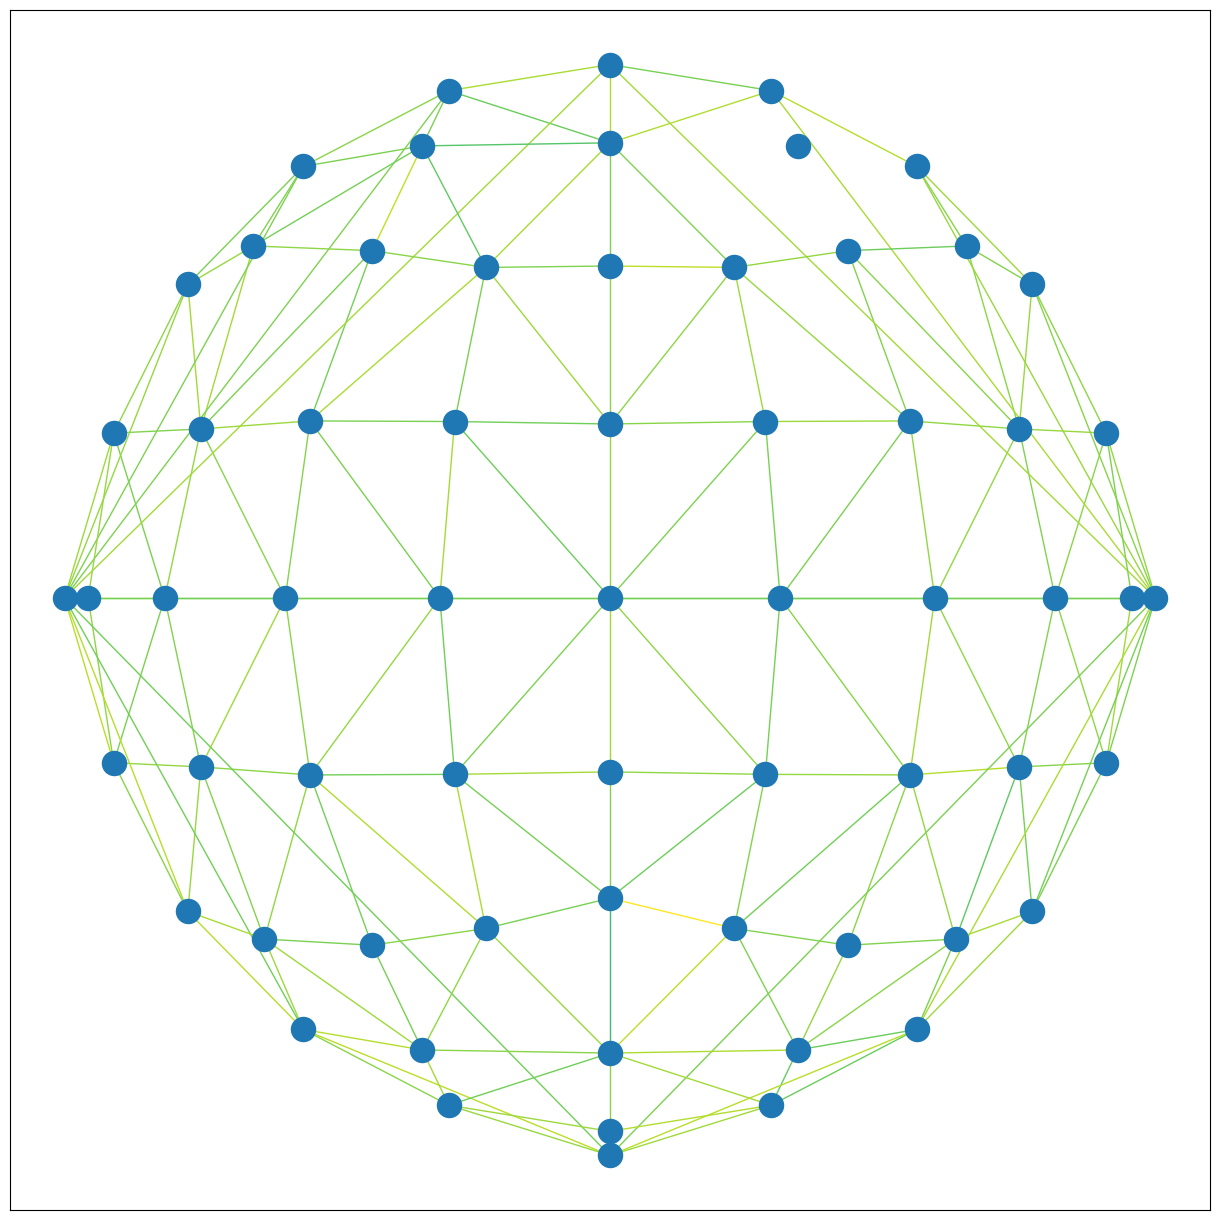

In [52]:
G = nx.from_numpy_array(model_GNN.adj.cpu().detach().numpy())
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

plt.figure(figsize=(12,12)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,:2], edgelist=np.array(edges)[a], edge_color=np.array(weights)[a])
plt.show()
plt.figure(figsize=(12,9)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,1:], edgelist=edges, edge_color=weights)
plt.show()
plt.figure(figsize=(12,9)) 
nx.draw(G, labels=ch_names, font_weight='bold', pos=points[:,[0, 2]], edgelist=edges, edge_color=weights)
plt.show()

проверить, нет ли проблемы в данных (координаты монтажа)